In [1]:
%reset

In [1]:
import numpy as np
import numpy.ma as ma
import pickle


import yellowbrick
from yellowbrick.style import reset_orig

# Immediately undo the automatic style change
reset_orig()
from matplotlib.collections import LineCollection
import matplotlib.image
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
from matplotlib import colors, cm
import itertools
from itertools import cycle
import copy
import math
import scipy.optimize
from scipy import ndimage
import os
from sklearn.neighbors import KernelDensity
from PIL import Image
import random
import matplotlib.mlab as mlab
import matplotlib.tri as tri
from sklearn import metrics
import matplotlib.patches as mpatches
from scipy.interpolate import NearestNDInterpolator
from sklearn.cluster import DBSCAN
from scipy.special import rel_entr
from sklearn.metrics import silhouette_score


from scipy.ndimage import gaussian_filter
import csv
import statsmodels.api as sm
from sklearn.cluster import KMeans
from sklearn.manifold import MDS
import seaborn as sns
import pandas as pd
import pdb

In [2]:
processed_states_filename = "data/class6_perth_processed_states.csv"
frequency_table_filename = "data/class6_perth_frequency_table.csv"

In [3]:
# reading the CSV file
reader = csv.reader(open(processed_states_filename, "r"), delimiter=",")
x = list(reader)
nrowList = len(x)
ncolList = len(x[0])
print(nrowList)

for i in range(nrowList):
    for j in range(ncolList):
        if (x[i][j] == ''):
            x[i][j] = '0.000'


allRowsExceptHeader = np.array(x[1::]).astype("float")

numrow, numcols = allRowsExceptHeader.shape

# Each row represents qubit distribution for 16 states
# The goal is to visualize uncertainty of qubit distributions across rows)
print(numrow)

9001
9000


[  24 1806 2022 ... 8359 4915 3115]
[]


/Users/priyabratasenapati/opt/miniconda3/envs/QVIS/lib/python3.11/site-packages/statsmodels/graphics/functional.py:665: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


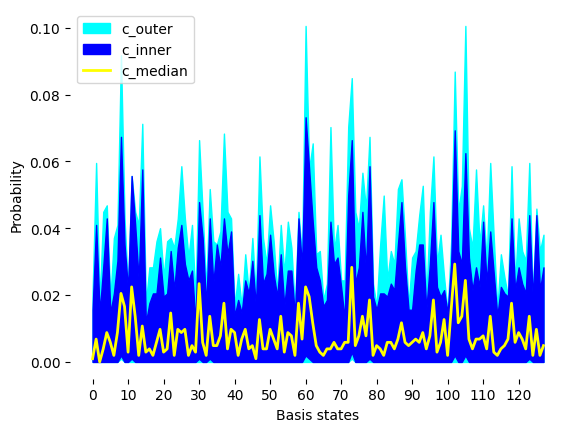

In [4]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)
plot_opts = {
    "c_outer":"cyan",
    "c_inner": "blue",
    "c_median": "yellow",
    # "draw_nonout":True,
    # "lw_median":"5"
}
fig, depth, ix_depth, ix_outliers = sm.graphics.fboxplot(allRowsExceptHeader[:, 1:], wfactor=3,labels=allRowsExceptHeader[:, 0].astype(int), ax=ax, plot_opts=plot_opts)
ax.set_xlabel("Basis states")
ax.set_ylabel("Probability")
# ax.set_xticks(np.arange(129, step=1) - 1)
ax.set_xticks(np.arange(128, step=10))

# ax.axis.get_xaxis().set_visible(False)
# ax.set_xticklabels(["","0", "1", "2", "3","4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14", "15"])
ax.set_frame_on(False)
# ax.get_legend().remove()
ax.legend(plot_opts)


# plt.xticks([])
#ax.set_xlim([-0.2, 11.2])
print(ix_depth)
print(ix_outliers)

plt.rcParams['figure.dpi'] = 100
# plt.axis("off")

9000
0.0006923648066265861


Text(0, 0.5, 'basis states')

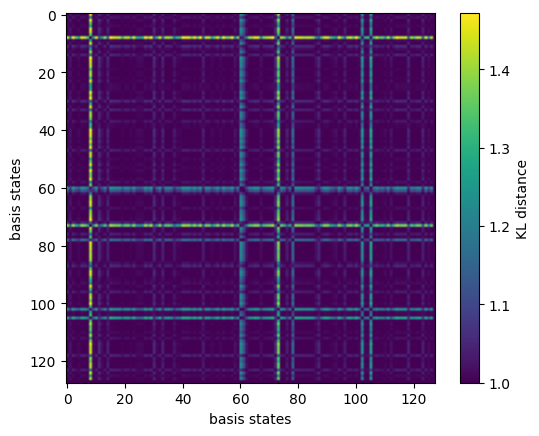

In [5]:
import matplotlib.pyplot as plt


def kl(p, q):
    p = np.asarray(p)
    q = np.asarray(q)

    #print(sum(rel_entr(p, q)))  
    #return sum(rel_entr(p, q))
    return np.sum(np.where(p != 0, p * np.log(p / q), 0))


# returns a smooth histogram type since we are dividing one distribution with other in the formula

def smoothed_hist_kl_distance(a, b, nbins=20, sigma=10):
    ahist, bhist = (np.histogram(a, bins=list(np.linspace(0, 0.09, num=nbins)))[0],
                    np.histogram(b, bins=list(np.linspace(0, 0.09, num=nbins)))[0])
    # pdb.set_trace()
    #print(ahist)
    #print(bhist)
    #print(list(np.linspace(0, 0.7, num=nbins)))
    # Creating histogram
    #fig, ax = plt.subplots(figsize =(10, 7))
    #ax.hist(a,bins=np.linspace(0, 0.7, num=nbins))
 
    # Show plot
    plt.show()

    asmooth, bsmooth = (gaussian_filter(ahist, sigma),
                        gaussian_filter(bhist, sigma))
    
    asmooth = asmooth/np.sum(asmooth)
    bsmooth = bsmooth/np.sum(bsmooth)
    
    #print(asmooth)
    #print(bsmooth)
    
    return kl(asmooth, bsmooth)


# Compute dissimilarity matrix
dissimilarity_mat = np.zeros((128,128))
a = allRowsExceptHeader[:, 1]
b = allRowsExceptHeader[:, 5]
print(len(b))
print(smoothed_hist_kl_distance(a,b) + smoothed_hist_kl_distance(b,a))


for i in range(127):
    for j in range(127):
        a = allRowsExceptHeader[:, i+1]
        b = allRowsExceptHeader[:, j+1]
        dissimilarity_mat[i,j] = smoothed_hist_kl_distance(a,b)+smoothed_hist_kl_distance(b,a)

# dissimilarity_mat = np.exp(dissimilarity_mat*10) #10 multiplied with dissimilarity matrix may be for better heat map indicator levels
#10 multiplied with dissimilarity matrix may be for better heat map indicator levels, also creates a bigger variance among clusters when increase the 
# value from 10 to 20 to 100 and so on
dissimilarity_mat = np.exp(dissimilarity_mat*20) 

plt.figure
plt.imshow(dissimilarity_mat)
plt.colorbar(label="KL distance", orientation="vertical")
plt.xlabel("basis states")
plt.ylabel("basis states")
# plt.tick_params(axis='x', which='both', bottom=False,
#                 top=False, labelbottom=False)



In [6]:
embedding = MDS(n_components=2, normalized_stress='auto', dissimilarity='precomputed',random_state=1)
X_transformed = embedding.fit_transform(dissimilarity_mat)

# Elbow score visualizer with metric=distortion for K-Means


Text(0.5, 0, 'clusters')

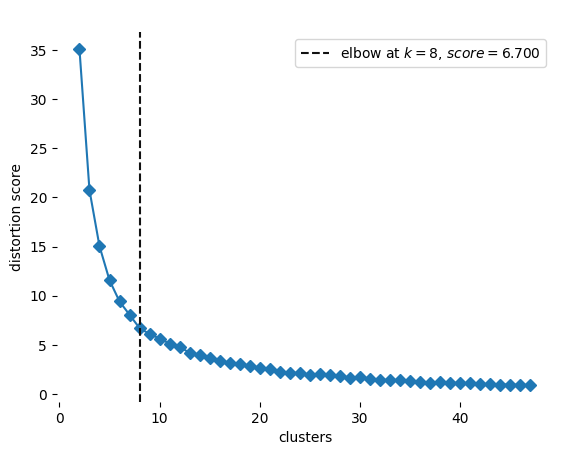

In [17]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot()

# The k-values might defere a bit everytime you run this code block

# Elbow score visualizer with metric=distortion
from yellowbrick.cluster import KElbowVisualizer

model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,48), timings=False, locate_elbow=True,  name = "Hello")
visualizer.fit(X_transformed)        # Fit the data to the visualizer
ax.legend(frameon=False)
visualizer.ax.set_frame_on(False)
visualizer.finalize()
visualizer.set_title(" ")
visualizer.ax.set_xlabel("clusters")

In [18]:
# set number of clusters by looking at the elbow plot
numClusters = 8


/var/folders/rm/nn_bnfs519b74g0n8p6y9pwc0000gn/T/ipykernel_26933/3552436039.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  representativeClusterMemberIndices[i] = memberIndices[tempIdx]


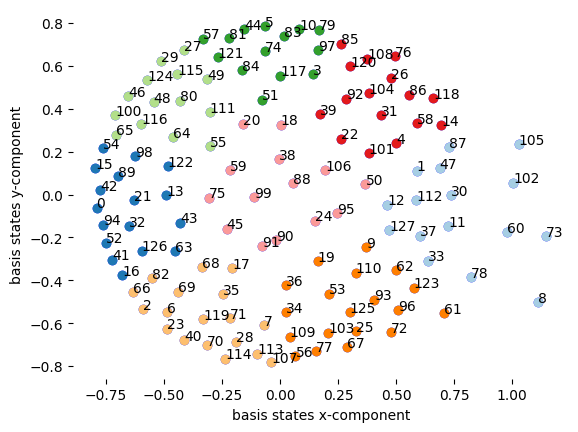

In [19]:

from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import matplotlib as mpl



plt.figure()
plt.scatter(X_transformed[:,0], X_transformed[:,1], c ="blue")
X_transformed.shape

kmeans = KMeans(n_clusters=numClusters, random_state=1, n_init="auto").fit(X_transformed)
memberIndicesList = list()


clusterFrequencies = np.zeros(numClusters)
clusterCenterFrequencies = np.zeros(numClusters)
clusterFrequencyArray = np.loadtxt(frequency_table_filename, delimiter=',')[1:]
clusterVariablesList = []
repIndexList = []

# finds the non zero indexes of the cluster frequency array so that we can check
# how many of the non zero indexes from top four states are present in each of the clusters
nonZeroIndexes = np.argsort(clusterFrequencyArray[np.nonzero(clusterFrequencyArray)])[::-1]


# Find closest point near cluster center to compute representative points
representativeClusterMemberIndices = np.zeros((numClusters))
klDivergenceVariance = np.zeros((numClusters))
percentageClusterIndices = np.zeros((numClusters))

for i in range(numClusters):
    clusterMembers = X_transformed[np.where(kmeans.labels_==i)]
    memberIndices = np.array(np.where(kmeans.labels_==i)).T
    minDist = 10000
    tempIdx = 0

    # this for loop below calculates the distance between the theoretical center point of a cluster
    # and finds out the state clostest to the cluster center
    tempDistanceArray = np.zeros((len(clusterMembers)))
    for j in range(len(clusterMembers)):
        x1 = kmeans.cluster_centers_[i][0]
        y1 = kmeans.cluster_centers_[i][1]
        x2 = clusterMembers[j][0]
        y2 = clusterMembers[j][1]
        dist = math.sqrt((x1-x2)**2 + (y1-y2)**2)
        tempDistanceArray[j] = dist
        if dist < minDist:
            minDist = dist
            tempIdx = j
    representativeClusterMemberIndices[i] = memberIndices[tempIdx]
    
    # klDivergenceVariance[i] = np.std(tempDistanceArray)
    klDivergenceVariance[i] = np.var(tempDistanceArray)

    # prepares the sum of each clusters by taking the values from clusterFreuencyArray prepared by taking the 
    # top two states for each circuit output
    clusterFrequencySum = 0

    clusterFrequencySum = np.sum([clusterFrequencyArray[index[0]] for index in memberIndices])
    clusterFrequencies[i] = clusterFrequencySum
    
    # records the cluster center states frequencies
    clusterCenterFrequencies[i] = clusterFrequencyArray[int(representativeClusterMemberIndices[i])]
    
    # percentage of how many of the indices of each of the clusters are present in the array of top four nonzero indices    
    percentageClusterIndices[i] = ((np.sum(np.isin(memberIndices, nonZeroIndexes)))/np.size(nonZeroIndexes)) * 100 

    repIndex = str(int(representativeClusterMemberIndices[i]))
    clist = []
    clist.append(clusterCenterFrequencies[i])
    clist.append(clusterFrequencySum)
    clist.append(klDivergenceVariance[i])
    clist.append(percentageClusterIndices[i])
    
    # clusterVariablesList contains a list of lists, where each of those list contains cluster frequency sum as first index and 
    # intra cluster variance as he second index
    clusterVariablesList.append(clist)
    
    # clusterValuesDict[repIndex: clist]
    repIndexList.append(repIndex)
    memberIndicesList.append(memberIndices)

top_member_index = 3
    

idx = np.argsort(representativeClusterMemberIndices)
klDivergenceVariance = klDivergenceVariance[idx]

#Normalize variance for ease of  colormapping
klDivergenceVariance = klDivergenceVariance/np.amax(klDivergenceVariance)


# Find intra-cluster variance of KL divergence
clusterValuesDict = dict(zip(repIndexList, clusterVariablesList))

        

t = np.where(kmeans.labels_==0)
# print(t)

colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00']

clusterCentroids = np.sort(representativeClusterMemberIndices)  

iter_labels = iter(np.sort(representativeClusterMemberIndices))
color_index=0

for i in range(numClusters):
    label = clusterCentroids[i]
    cluster_index = np.where(representativeClusterMemberIndices==label)[0][0]
    plt.scatter(X_transformed[np.where(kmeans.labels_==cluster_index),0], 
                X_transformed[np.where(kmeans.labels_==cluster_index),1], c = colors[i])

    lenX = len(X_transformed[np.where(kmeans.labels_== cluster_index)])
    for j in range(lenX):
            plt.annotate(str(np.where(kmeans.labels_== cluster_index)[0][j]), (X_transformed[np.where(kmeans.labels_== cluster_index),0][0][j], 
                                                                X_transformed[np.where(kmeans.labels_== cluster_index),1][0][j] + 0.001))
    color_index+=1        

plt.xlabel("basis states x-component")
plt.ylabel("basis states y-component")
cmap_test = plt.get_cmap('viridis',  len(colors))

norm_test = mpl.colors.Normalize() 
cmappable = ScalarMappable(cmap=cmap_test, norm=norm_test)
plt.gca().set(frame_on=False)
plt.grid(False)
plt.show()


/var/folders/rm/nn_bnfs519b74g0n8p6y9pwc0000gn/T/ipykernel_26933/3694793882.py:11: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(data = [allRowsExceptHeader[:,labels[i]+1] for i in range(numClusters)], color = "#7fcdbb", scale = 'width')
/var/folders/rm/nn_bnfs519b74g0n8p6y9pwc0000gn/T/ipykernel_26933/3694793882.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)


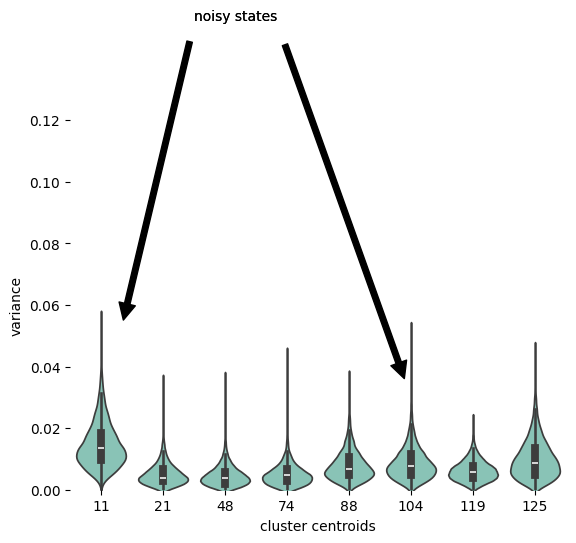

CLUSTERING AS PER VARIANCE


In [22]:
# use the link below for manually entering color maps
# https://waldyrious.net/viridis-palette-generator/ 

import matplotlib.pyplot as plt


labels = ['t'+str(i+1) for i in range(numClusters)]
for i in range(numClusters):
    labels[i] =  int(representativeClusterMemberIndices[i])
labels = np.sort(labels)
ax = sns.violinplot(data = [allRowsExceptHeader[:,labels[i]+1] for i in range(numClusters)], color = "#7fcdbb", scale = 'width')
ax.set_xticklabels(labels)
ax.set_ylim([0, 0.12])
ax.set(frame_on=False)  # New

ax.set_xlabel("cluster centroids")
ax.set_ylabel("variance")

plt.annotate('noisy states', xy=(0.3, 0.05), xycoords='data',
            xytext=(0.25, 1.3), textcoords='axes fraction',
            va='top', ha='left',
            arrowprops=dict(facecolor='black', shrink=0.05))

plt.annotate('noisy states', xy=(5.0, 0.03), xycoords='data',
            xytext=(0.25, 1.3), textcoords='axes fraction',
            va='top', ha='left',
            arrowprops=dict(facecolor='black', shrink=0.05))

# plt.annotate('noisy states', xy=(6.9, 0.03), xycoords='data',
#             xytext=(0.25, 1.3), textcoords='axes fraction',
#             va='top', ha='left',
#             arrowprops=dict(facecolor='black', shrink=0.05))


plt.grid(False)
plt.show()
print("CLUSTERING AS PER VARIANCE")



/var/folders/rm/nn_bnfs519b74g0n8p6y9pwc0000gn/T/ipykernel_26933/444988058.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  representativeClusterMemberIndices[i] = memberIndices[tempIdx]


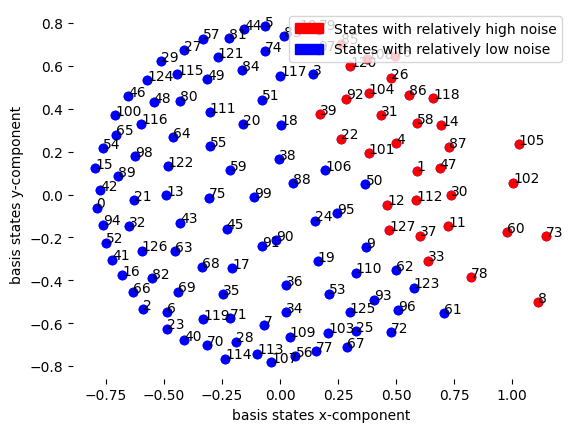

In [23]:
import matplotlib.pyplot as plt

embedding = MDS(n_components=2, normalized_stress='auto', dissimilarity='precomputed',random_state=1)
X_transformed = embedding.fit_transform(dissimilarity_mat)


plt.figure()
plt.scatter(X_transformed[:,0], X_transformed[:,1], c ="blue")
X_transformed.shape

kmeans = KMeans(n_clusters=numClusters, random_state=1, n_init="auto").fit(X_transformed)
memberIndicesList = list()


# memberIndicesList = list()
clusterFrequencies = np.zeros(numClusters)
clusterCenterFrequencies = np.zeros(numClusters)
clusterFrequencyArray = np.loadtxt(frequency_table_filename, delimiter=',')[1:]
# clusterValuesDict =dict()
clusterVariablesList = []
repIndexList = []
# finds the non zero indexes of the cluster frequency array so that we can check
# how many of the non zero indexes from top four states are present in each of the clusters
nonZeroIndexes = np.argsort(clusterFrequencyArray[np.nonzero(clusterFrequencyArray)])[::-1]


# Find closest point near cluster center to compute representative points
representativeClusterMemberIndices = np.zeros((numClusters))
klDivergenceVariance = np.zeros((numClusters))
percentageClusterIndices = np.zeros((numClusters))

for i in range(numClusters):
    clusterMembers = X_transformed[np.where(kmeans.labels_==i)]
    memberIndices = np.array(np.where(kmeans.labels_==i)).T
    minDist = 10000
    tempIdx = 0

    # this for loop below calculates the distance between the theoretical center point of a cluster
    # and finds out the state clostest to the cluster center
    tempDistanceArray = np.zeros((len(clusterMembers)))
    for j in range(len(clusterMembers)):
        x1 = kmeans.cluster_centers_[i][0]
        y1 = kmeans.cluster_centers_[i][1]
        x2 = clusterMembers[j][0]
        y2 = clusterMembers[j][1]
        dist = math.sqrt((x1-x2)**2 + (y1-y2)**2)
        tempDistanceArray[j] = dist
        if dist < minDist:
            minDist = dist
            tempIdx = j
    representativeClusterMemberIndices[i] = memberIndices[tempIdx]
    klDivergenceVariance[i] = np.var(tempDistanceArray)

    # prepares the sum of each clusters by taking the values from clusterFreuencyArray prepared by taking the 
    # top two states for each circuit output
    clusterFrequencySum = 0
    clusterFrequencySum = np.sum([clusterFrequencyArray[index[0]] for index in memberIndices])
    clusterFrequencies[i] = clusterFrequencySum

    # records the cluster center states frequencies
    clusterCenterFrequencies[i] = clusterFrequencyArray[int(representativeClusterMemberIndices[i])]
    
    # percentage of how many of the indices of each of the clusters are present in the array of top four nonzero indices
    percentageClusterIndices[i] = ((np.sum(np.isin(memberIndices, nonZeroIndexes)))/np.size(nonZeroIndexes)) * 100 

    repIndex = str(int(representativeClusterMemberIndices[i]))
    clist = []
    clist.append(clusterCenterFrequencies[i])
    clist.append(clusterFrequencySum)
    clist.append(klDivergenceVariance[i])
    clist.append(percentageClusterIndices[i])
    # clusterVariablesList contains a list of lists, where each of those list contains cluster frequency sum as first index and 
    # intra cluster variance as he second index
    clusterVariablesList.append(clist)
    repIndexList.append(repIndex)
    
    memberIndicesList.append(memberIndices)

top_member_index = 3

idx = np.argsort(representativeClusterMemberIndices)
klDivergenceVariance = klDivergenceVariance[idx]

#Normalize variance for ease of  colormapping
klDivergenceVariance = klDivergenceVariance/np.amax(klDivergenceVariance)
clusterValuesDict = dict(zip(repIndexList, clusterVariablesList))
t = np.where(kmeans.labels_==0)
clusterCentroids = np.sort(representativeClusterMemberIndices)  
iter_labels = iter(np.sort(representativeClusterMemberIndices))
color_index=0

highlighted_states = [11, 104]

for i in range(numClusters):
    label = clusterCentroids[i]
    if (label == highlighted_states[0] or label== highlighted_states[1]):
        cluster_index = np.where(representativeClusterMemberIndices==label)[0][0]
        plt.scatter(X_transformed[np.where(kmeans.labels_==cluster_index),0], 
                    X_transformed[np.where(kmeans.labels_==cluster_index),1], c = "red")
        lenX = len(X_transformed[np.where(kmeans.labels_== cluster_index)])
        for j in range(lenX):
                plt.annotate(str(np.where(kmeans.labels_== cluster_index)[0][j]), (X_transformed[np.where(kmeans.labels_== cluster_index),0][0][j], 
                                                                    X_transformed[np.where(kmeans.labels_== cluster_index),1][0][j] + 0.001))
    else:
        cluster_index = np.where(representativeClusterMemberIndices==label)[0][0]
        plt.scatter(X_transformed[np.where(kmeans.labels_==cluster_index),0], 
                    X_transformed[np.where(kmeans.labels_==cluster_index),1], c = "blue")
        lenX = len(X_transformed[np.where(kmeans.labels_== cluster_index)])
        for j in range(lenX):
                plt.annotate(str(np.where(kmeans.labels_== cluster_index)[0][j]), (X_transformed[np.where(kmeans.labels_== cluster_index),0][0][j], 
                                                                    X_transformed[np.where(kmeans.labels_== cluster_index),1][0][j] + 0.001)) 

    color_index+=1        



plt.xlabel("basis states x-component")
plt.ylabel("basis states y-component")
red_patch = mpatches.Patch(color='red', label='States with relatively high noise')
blue_patch = mpatches.Patch(color='blue', label='States with relatively low noise')
# red_patch.set_linewidth(0.01)
plt.legend(handles=[red_patch, blue_patch])
plt.gca().set(frame_on=False)
plt.grid(False)
plt.show()